# Schrödinger Bridge Scheme for Gradient Flow of KL Divergence

In this notebook, we use our Schrödinger bridge scheme for approximating the explicit Euler discretization of the gradient flow of KL divergence. We work with the simple setting of Gaussian starting measure. 

In [10]:
import numpy as np
from scipy.special import expit
from scipy.stats import norm
from tqdm import tqdm
import matplotlib.pyplot as plt
from estimate_SB import _gibbs_one_iter, schbridge, sinkhorn, cost_matrix
from BP_scheme_KL import custom_resample, kl_SB_scheme_gibbs
from matplotlib.animation import FuncAnimation

In [2]:
def cost_matrix(X, Y):
    """L2 cost matrix
    """
    n = X.shape[0]
    return (X.reshape((n,1)) - X.reshape((1,n)))**2

Suppose I have $(x_1, \dots, x_n)$ observed from $\rho_0$ to start with. I want to conduct an SB scheme on these samples for minimizing 
$$\mathcal{F}(\rho) := \frac{1}{2} KL(\rho | e^{-g}).$$

Here we take $\rho = \mathcal{N}(0, \eta^2)$ and $g = x^2/2$. Assuming $\eta^2 < 1$, the valid surrogate density is $\sigma = \rho e^g = \mathcal{N}(0, \eta^2/(1-\eta^2))$.



In [3]:
# Create Particles for forward process
n = 500
eps = 0.001
mu, sigma_squared, sigma = 0, 4, 2
X = np.random.normal(mu, sigma, n)
cost_mat = cost_matrix(X, X)

Let us look at the Schrodinger bridge when we use the histogram of data.

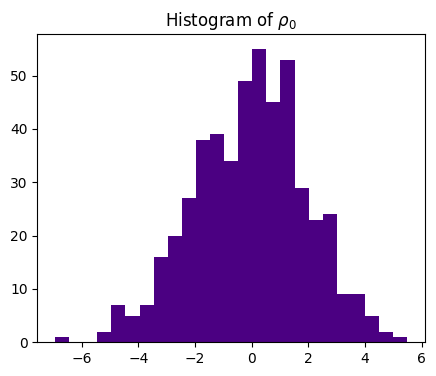

In [4]:
plt.figure(figsize = (5,4))
plt.hist(X, bins=25, color='indigo')
plt.title(r"Histogram of $\rho_0$")
plt.show()

Recall that the SB scheme with the starting measure $\rho = \mathcal{N}(0, \eta^2)$ is
$$\rho_\epsilon^* = (Id + \nabla f_{\epsilon, \sigma})_\# \rho,$$
where $\sigma = \mathcal{N}(0, \eta^2/(1-\eta^2))$. Samples from $\sigma$ are not immediately available. But note that if $x_1, \dots, x_n$ are iid samples from $\mathcal{N}(0, \eta^2)$, then $y_i = x_i/\sqrt{1-\eta^2}$ are iid samples from $\mathcal{N}(0, \eta^2/(1-\eta^2))$. Therefore we estimate $\sigma$ by 

$$\sigma_n = \frac{1}{n} \sum_{i=1}^{n} \delta_{x_i/\sqrt{1-\hat{\eta}^2}}.$$

Now the SB scheme is 

$$x_i \mapsto x_i + \nabla f_{\epsilon, \sigma_n}(x_i)$$
We know that $E_{\pi_{\epsilon, \sigma_n}}[Y | X = x_i] = x_i - \nabla f_{\epsilon, \sigma_n}(x_i)$. Therefore, we want to calculate the barycentric projection using an approximation of $\pi_{\epsilon, \sigma_n}$. 

Let this be $\hat{\pi}_{\epsilon, \sigma_n}$ calculated using method above using Sinkhorn or Gibbs sampling. Then we have that $\hat{\pi}_{\epsilon, \sigma_n} \in [0,1]^{n \times n}$ is matrix. And note that
\begin{align*}
\nabla \hat{f}_{\epsilon, \sigma_n}(x_i) &= x_i - E_{\hat{\pi}_{\epsilon, \sigma_n}}[Y|X=x_i]
\end{align*}
However we can only estimate the conditional expectation when conditioning $X$ on one of the elements in the set $\{y_1, \dots, y_n\}$


In [8]:
def draw_gaussian(mean, std_dev):
    # Generate data points for the x-axis
    x = np.linspace(mean - 3*std_dev, mean + 3*std_dev, 1000)

    # Compute the probability density function (PDF) for each data point
    pdf_values = norm.pdf(x, mean, std_dev)

    return x, pdf_values

def forward_SB_var(sigma_squared, eps, k=1):

    surrogate_var = sigma_squared/(sigma_squared - 1)

    new_sigma_squared = ((surrogate_var/(np.sqrt((surrogate_var**2) + (eps**2)/4) + eps/2))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    else:
        return forward_SB_var(new_sigma_squared, eps, k=k-1)

def reverse_SB_var(sigma_squared, eps, k=1):

    surrogate_var = sigma_squared/(sigma_squared - 1)

    new_sigma_squared = ((2-(sigma_squared/(np.sqrt((sigma_squared**2) + (eps**2)/4) + eps/2)))**2)*sigma_squared

    if k==1:
        return new_sigma_squared
    else:
        return reverse_SB_var(new_sigma_squared, eps, k=k-1)

In [9]:
def update_plot(frame, SB_steps, steps, eps, sigma_squared, forward, xlim, ylim):
    plt.clf()  # Clear the previous plot (if any)
    
    # Your plotting logic for each frame
    step = steps[frame]
    plt.hist(SB_steps[frame], density=True, alpha=0.6, bins=30, color='lightblue', edgecolor='white')
    plt.title(f'Steps: {step}, Time: {eps*step}')
    plt.xlim(-xlim, xlim)
    plt.ylim(0, ylim)

    if forward:
        true_var = 1 + (sigma_squared - 1)*np.exp(-step*eps)
        SB_var = forward_SB_var(sigma_squared, eps, k=step)
    else:
        true_var = 1 + (sigma_squared - 1)*np.exp(step*eps)
        SB_var = reverse_SB_var(sigma_squared, eps, k=step)

    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(true_var))
    plt.plot(x, pdf_values, label=r'$\rho_t$', color='blue', linewidth=4)
    x, pdf_values = draw_gaussian(mean=0, std_dev=np.sqrt(SB_var))
    plt.plot(x, pdf_values, label=r'$\rho^*_t$', color='green')
    plt.legend()

(2, 500)


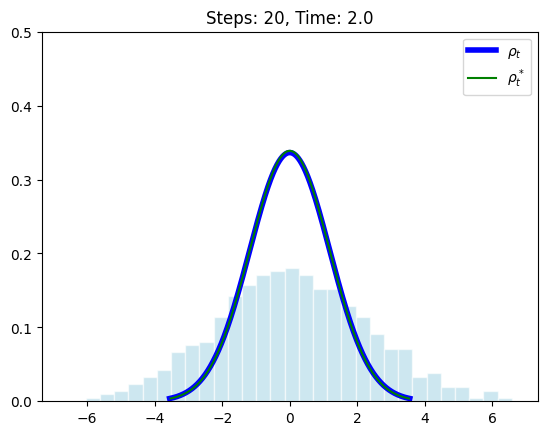

In [15]:
# Create forward animations

mu, sigma_squared, sigma = 0, 4, 2
for e in [0.1]: 

    max_steps = int(2/e)
    steps = 10*np.arange(1, (max_steps//10)+1)

    # Set the number of frames
    num_frames = len(steps)

    ## Gibbs
    file_path = f'X_SB_Gibbs_forward_eps{e}.npy'
    X_SB_Gibbs = np.load(file_path)
    print(X_SB_Gibbs.shape)

    # Create a figure
    fig, ax = plt.subplots()

    # Create the animation
    animation = FuncAnimation(fig, update_plot, frames=num_frames, fargs=(X_SB_Gibbs, steps, e, sigma_squared, True, 3*np.sqrt(6), .5), interval=10)
    animation.save(f'Gibbs_forward_KL_Eps{e}.gif', writer='imagemagick', fps=2)
    # Show the animation
    plt.show()
